<a href="https://colab.research.google.com/github/ishaan27chaturvedi/Text-Classification/blob/main/Text_classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECS 7001 - NN & NNLP**

## **Lab 2: LSTM for Text Classification**

<br>

**February 2nd and 3rd**

In Lab 2, you trained word embeddings by casting the unsupervised learning problem as a binary classification problem (i.e. using the skip-gram model). This week, you will build an LSTM model to classify movie reviews as either positive or negative. After training, you will extract the word embeddings learned by the model.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Getting the Dataset**

You will be using the imdb dataset from Lab 0. This is a dataset of 25,000 movie reviews from IMDB, labeled by sentiment - positive (1) or negative (0). 
<br>

The reviews have been preprocessed, and each review is encoded as a list of word indices. Last week, you assigned the indices to the word randomly (or in order of their first appearance in the corpus) but in this preprocessed corpus, the words are indexed by overall frequency in the dataset, such that a word with index 3 occurs more frequently than a word with index 10.
<br>

In the following blocks of code in this section, we will load and visualize the data.


In [ ]:
from tensorflow.keras import datasets

imdb = datasets.imdb

In [ ]:
%%capture

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
# If you want to explore this further, you may look up the source_code for load_data here
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/datasets/imdb.py#L31-L162
OFFSET = 2

# for more information on the load_data method, type(help(load_data))
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=OFFSET)

***Sanity Check***

Each instance in the training data is a list of word indices representing the words in a movie review.

Each label is 1 if that review is positive, else 0.

In [ ]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [ ]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically). 

Keras provides a way to do this.  In this section, you will use the keras.preprocessing.sequence method <pad_sequences> handle padding and truncating.

**Hints**

*  help(pad_sequences) will give you more information about how this works.
*  You can experiment with 'pre' vs 'post' padding/truncating. In practice, 'pre' padding is more effective for our purposes; can you hypothesize about why this is?
*  Since we have reserved 0 for \<PAD\>, your pad value should be set to 0.
*  The maximum length has been specified below as MAX_LENGTH.

*If you use post-pad, meaningful words from your input will be washed out in the end, so model kind of “forgets” what is in the beginning, so pre-pad is more powerful.*

In [ ]:
from keras.preprocessing.sequence import pad_sequences


MAX_LENGHT = 500

# YOUR CODE GOES HERE
padded_train_data = pad_sequences(train_data, maxlen = MAX_LENGHT, value =0, padding='pre')
padded_test_data = pad_sequences(test_data, maxlen = MAX_LENGHT, value =0, padding='pre')

***Sanity Check***

For the first training example, print its length and the padded sequence to see the effect of your padding process. 

PS: Pre-padding was used for the output you see below.

In [ ]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

In this section, you will use the keras Model API to build a classification model.

*   The first step is to tell the model what sort of input to expect using the keras \<Input\> layer 
*   The second step is to add an embedding layer like we did last week. 
This embedding layer creates a lookup table of the form {word:embedding} for each of the unique words in our corpus. Use EMBED_SIZE = 100 (i.e each word is represented by a 100D vector such that each movie review is 500 X 100 in dimension.  Don't forget to set mask_zero=True since we are using 0 index as out padding.
*  The third step is to add an LSTM with 100 units. By leaving 'return_sequences' as False, the output of this model will be the output of the final time step of the LSTM. https://keras.io/api/layers/recurrent_layers/lstm/ 
*  The final layer of the model is a fully connected (Dense) layer. Can you figure out what activation function would be appropriate for this layer given the binary nature of the task?
*  The model should be compiled with a 'binary_crossentropy' loss function, an 'adam' optimizer. We also want to visualize the model accuracy during training so the 'metrics' parameter of the compile method should be set to ['accuracy'].


*   *The input layer length shall be 500 as each input string is 500 words long*
*   *Embed layer will give us a 500x100 vector for each row in the input batch. Setting mask_zero=True helps the embed layer to understand that we have used zero as padding and to not consider it as a real word. Therefore, it is masked.*
*  *If return_sequence=True, the LSTM will output the hidden state for each of the timesteps, not just the final timestep. Therefore it will return a sequence of outputs* 
*  *Since it is a binary classification task, sigmoid is obviously the most appropriate activation function.*




In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model

EMBED_SIZE = 100
# YOUR CODE GOES HERE

input_1 = Input(shape=(500,), dtype='int32')
embedding_1 = Embedding( input_length=500, input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, name='embed_layer',
                        embeddings_initializer='glorot_uniform', mask_zero=True)(input_1)
lstm_1 = LSTM(100)(embedding_1)
dense_1 = Dense(1, activation='sigmoid')(lstm_1)

model_1 = Model(inputs=[input_1], outputs=[dense_1])

model_1.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics=['accuracy'])


***Sanity Check***

Print the model summary and visualize it using vis_utils.

In [ ]:
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 embed_layer (Embedding)     (None, 500, 100)          1000000   
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


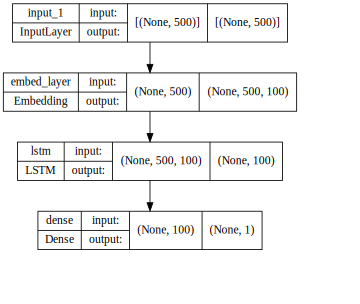

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_1, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


### **4. Training the Model**

A model can memorize the training data (this is called 'overfitting' and when it does so, it's training accuracy can continue to go up but it's accuracy on previously unseen (i.e. non-training) examples can be very poor. To ensure that this doesn't happen, researchers often intermittently check the performance of a model being trained on a held back dataset called the ***validation dataset***. This way, 'early stopping' or 'random search' can be used to select the model that will generalize best to unseen data. 
<br>


In this lab, you will just plot training accuracy against validation accuracy to monitor the progress of your model. And, using the plot, you will theorize about what the optimal stopping point for your model should have been.


**Step 1: Getting a validation dataset**

Before we begin training, you will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function. 

In [ ]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

Alternatively, we could have chosen to set validation_size=0.08 in our model.fit() function below instead of passing in a separate validation dataset.

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [ ]:
history = model_1.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 16s 569ms/step - loss: 0.6400 - accuracy: 0.6436 - val_loss: 0.5573 - val_accuracy: 0.8070
Epoch 2/6
23/23 [==============================] - 12s 525ms/step - loss: 0.3856 - accuracy: 0.8503 - val_loss: 0.3372 - val_accuracy: 0.8625
Epoch 3/6
23/23 [==============================] - 13s 557ms/step - loss: 0.2521 - accuracy: 0.9049 - val_loss: 0.2991 - val_accuracy: 0.8795
Epoch 4/6
23/23 [==============================] - 13s 549ms/step - loss: 0.1865 - accuracy: 0.9350 - val_loss: 0.2895 - val_accuracy: 0.8795
Epoch 5/6
23/23 [==============================] - 13s 557ms/step - loss: 0.1451 - accuracy: 0.9536 - val_loss: 0.3021 - val_accuracy: 0.8825
Epoch 6/6
23/23 [==============================] - 13s 550ms/step - loss: 0.1167 - accuracy: 0.9659 - val_loss: 0.3298 - val_accuracy: 0.8770


**Step 3: Visualize the model plot**

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=71e01b1e4e900c30b2af5d04cabfdff6c79964583885e632e0f5bb3dd14ef358
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=5f069c158fa7f6e966082cda98ae24284159053e91a3447c557ba0561163e5ef
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=92e26a1a65a72c67f5fe32914ddac12deb7db817e034fc62095de25762d969a9
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

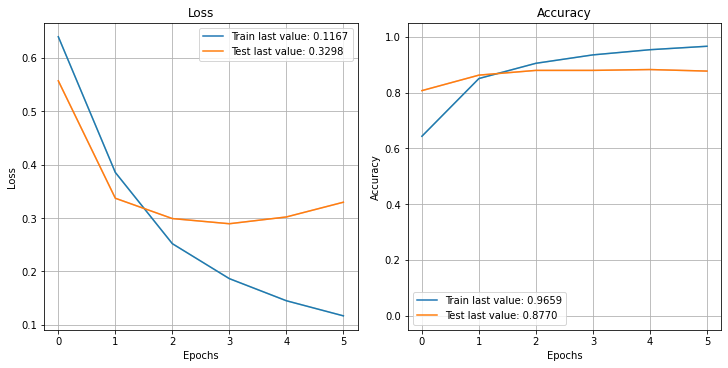

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

In [ ]:
results = model_1.evaluate(padded_test_data, test_labels, batch_size=1000)

print('test_loss:', results[0], 'test_accuracy:', results[1])

25/25 [==============================] - 3s 102ms/step - loss: 0.3605 - accuracy: 0.8646
test_loss: 0.3605085015296936 test_accuracy: 0.8645600080490112


**Based on the accuracy plot, what do you think the optimal stopping point for your model should
have been?**

*Early stopping entails stopping the model training when the validation accuracy starts to reduce. Here we see that after the 2nd epoch the validation accuracy stabilizes and the training accuracy continues increasing, which could signify overfitting. We can also see that the validation loss is significant and stabilizing after the 2nd epoch. Therefore, the model should early stop its training at the 2nd epoch.*

## Model with early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=1, mode='min', verbose=1, min_delta=0.01)

history = model_1.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y), callbacks = [callback])

Epoch 1/6
23/23 [==============================] - 17s 594ms/step - loss: 0.6502 - accuracy: 0.6303 - val_loss: 0.4792 - val_accuracy: 0.8215
Epoch 2/6
23/23 [==============================] - 13s 550ms/step - loss: 0.3852 - accuracy: 0.8483 - val_loss: 0.3195 - val_accuracy: 0.8695
Epoch 3/6
23/23 [==============================] - 13s 550ms/step - loss: 0.2599 - accuracy: 0.9004 - val_loss: 0.2985 - val_accuracy: 0.8870
Epoch 4/6
23/23 [==============================] - 13s 550ms/step - loss: 0.1963 - accuracy: 0.9295 - val_loss: 0.2871 - val_accuracy: 0.8745
Epoch 5/6
23/23 [==============================] - 13s 562ms/step - loss: 0.1545 - accuracy: 0.9486 - val_loss: 0.3010 - val_accuracy: 0.8805
Epoch 5: early stopping


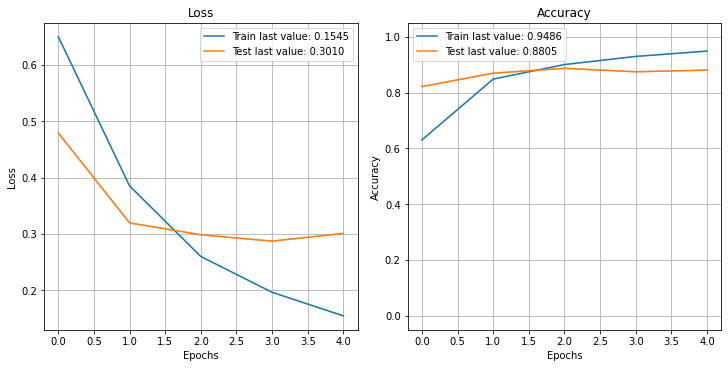

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

### **5. Evaluating the Model on the Test Data**

Evaluate the model on the padded test data using the code in the following cell block.

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results = model_1.evaluate(padded_test_data, test_labels, batch_size=1000)

print('test_loss:', results[0], 'test_accuracy:', results[1])

25/25 [==============================] - 3s 98ms/step - loss: 0.3181 - accuracy: 0.8714
test_loss: 0.3180568814277649 test_accuracy: 0.8714399933815002


###**6. Extracting the Word Embeddings**

Extract the word embeddings from the embedding layer model like we did in the last lab. 

**Hints**

*  You can use model.get_layer(layer_name).get_weights()[0] or model.layers[layer_number].get_weights()[0].  The layer number indicates the order in which the layers were added to the model.

*  If you didn't explicitly name your layers, you can check layer names and numbers about the order from model.summary() or by calling model.layers

In [ ]:
word_embeddings = model_1.get_layer('embed_layer').get_weights()[0]

***Sanity Check***

Print the shape of the word embeddings using the line of code below. It should return (VOCAB_SIZE, EMBED_SIZE)

In [ ]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


###**7. Visualizing the Reviews**

In this section, we will view the effects of padding the dataset. 

As mentioned before, Keras already preprocessed the corpus. In this preprocessed corpus, all the words have already been mapped to indices and were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent word in the dataset, and so on. However, when we loaded our training dataset, we reserved the first 3 indices - 0, 1, 2 - for \<PAD\>, \<START\> and \<UNK\>. Additionally, we limited our vocabulary to only the top 10000 most frequent words (9997 if you exclude the padding). We will now visualize what a movie review will look like with these changes




**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary using the following lines of code.

In [ ]:
# in this dictionary, the words start from 1, 0 is reserved for padding but 
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

1654784/1641221 [==============================] - 0s 0us/step



**Step 2: Create a the idx2word dictionary**

In [ ]:
# YOUR CODE GOES HERE
idx2word = {v: k for k, v in word2idx.items()}

In [ ]:
idx2word

{1410: 'woods',
 2347: 'hanging',
 2291: 'woody',
 6748: 'arranged',
 2340: 'bringing',
 1638: 'wooden',
 4012: 'errors',
 3232: 'dialogs',
 361: 'kids',
 5036: 'uplifting',
 7095: 'controversy',
 9880: 'projection',
 7182: 'stern',
 5623: 'morally',
 5285: 'wang',
 180: 'want',
 2105: 'travel',
 6704: 'barbra',
 3932: 'dinosaurs',
 354: 'wrong',
 4762: 'subplots',
 9094: 'welcomed',
 6705: 'butcher',
 1182: 'fit',
 1929: 'screaming',
 4289: 'fix',
 9656: 'hurting',
 301: 'effects',
 8777: 'barton',
 6194: 'ingrid',
 7918: 'adapt',
 4013: 'disturbed',
 1287: 'purpose',
 6794: 'olds',
 886: 'needed',
 1299: 'master',
 5401: 'positively',
 9838: 'zatoichi',
 546: 'feeling',
 5624: 'affairs',
 7801: 'wholesome',
 1359: 'cinematic',
 4990: 'tech',
 659: 'saying',
 8424: 'padded',
 5747: 'tempted',
 7478: 'plate',
 3901: 'altogether',
 8778: 'lds',
 1779: 'nicely',
 4590: 'mummy',
 774: 'lots',
 9261: 'lotr',
 9881: 'irs',
 6889: 'ira',
 7695: 'discipline',
 875: 'nature',
 3902: 'superfici


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [ ]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

###**8. Visualizing the Word_Embeddings**

Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3

In [ ]:
# YOUR CODE GOES HERE
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                 0         1         2         3         4         5   \
woods     -0.012299 -0.013127  0.013058  0.023481 -0.008153  0.014934   
hanging   -0.023498  0.022725  0.024090  0.012466  0.013393  0.020466   
woody     -0.014919 -0.005693 -0.000013  0.005934  0.017326  0.003565   
arranged  -0.021514  0.024683 -0.021233 -0.026707  0.014201 -0.009639   
bringing  -0.020868 -0.003114  0.014555 -0.004266 -0.016562 -0.000792   
wooden     0.021337  0.007044 -0.015054 -0.016900  0.005097  0.022393   
errors    -0.001106 -0.021337  0.012621 -0.020227  0.001814  0.020656   
dialogs   -0.014772  0.012164  0.022216  0.015329 -0.015301 -0.012940   
kids       0.002337  0.021296  0.011444 -0.031177  0.001404  0.020915   
uplifting  0.018451  0.022746 -0.010189  0.011272  0.021757 -0.010721   

                 6         7         8         9   ...        90        91  \
woods     -0.018859 -0.016726  0.015144 -0.005391  ... -0.020628  0.004200   
hanging   -0.009895 -0.009836 -0.003413 

#### Visualising the word embedding for the first 10 words

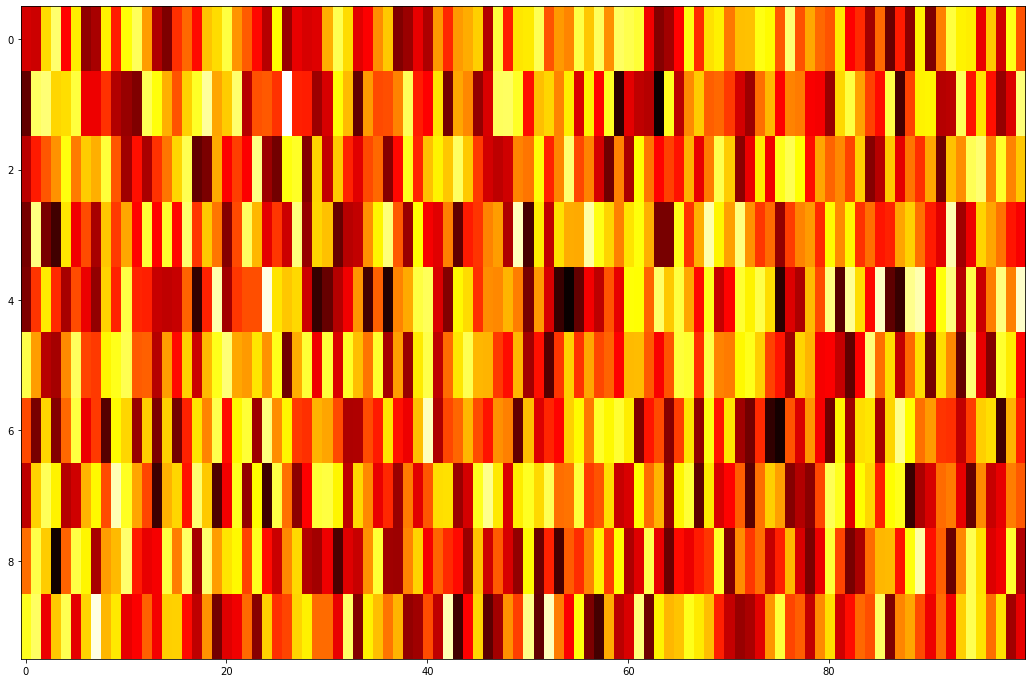

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 12))
ax.imshow(word_embeddings[:10], cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

###**9. Plot your Word Embeddings using t-SNE**


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


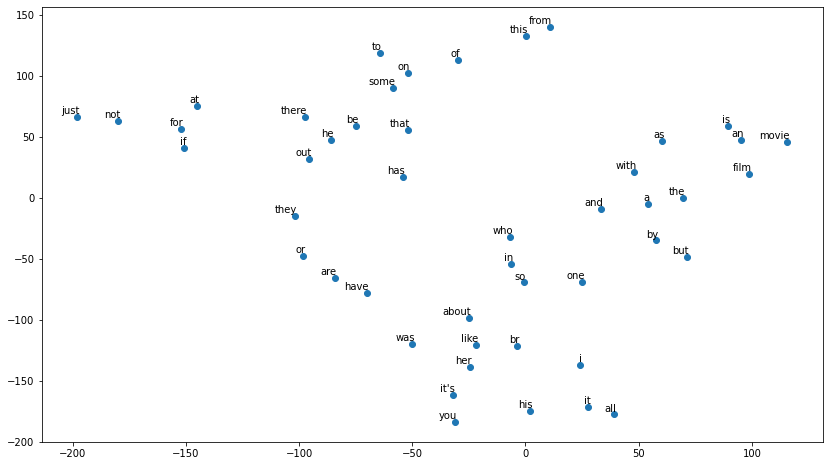

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        


###**10. Questions**

1. Create a new model that is a copy of the model step 3. To this new model,add two dropout layers, one between the embedding layer and the LSTM layer and another between the LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?

2. Experiment with training the model with batch sizes of 1, 32, len(training_data). What do you observe?

3. (optional) Can you retrain with a Bidirectional LSTM instead of an LSTM? What do you observe about the Bi-LSTM model?


## 1. NEW MODEL with dropouts


The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Dropout
from keras.models import Model

EMBED_SIZE = 100
# YOUR CODE GOES HERE

input_1 = Input(shape=(500,), dtype='int32')
embedding_1 = Embedding( input_length=500, input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, name='embed_layer',
                        embeddings_initializer='glorot_uniform', mask_zero=True)(input_1)
dropout_1 = Dropout(rate=0.2)(embedding_1)
lstm_1 = LSTM(100)(dropout_1)
dropout_2 = Dropout(rate=0.2)(lstm_1)
dense_1 = Dense(1, activation='sigmoid')(dropout_2)

model_2 = Model(inputs=[input_1], outputs=[dense_1])

model_2.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics=['accuracy'])


In [ ]:
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 500)]             0         
                                                                 
 embed_layer (Embedding)     (None, 500, 100)          1000000   
                                                                 
 dropout_6 (Dropout)         (None, 500, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-tra

In [ ]:
history = model_2.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 17s 639ms/step - loss: 0.6554 - accuracy: 0.6220 - val_loss: 0.5466 - val_accuracy: 0.7740
Epoch 2/6
23/23 [==============================] - 13s 579ms/step - loss: 0.4280 - accuracy: 0.8334 - val_loss: 0.3437 - val_accuracy: 0.8720
Epoch 3/6
23/23 [==============================] - 13s 558ms/step - loss: 0.2738 - accuracy: 0.8973 - val_loss: 0.3054 - val_accuracy: 0.8745
Epoch 4/6
23/23 [==============================] - 13s 552ms/step - loss: 0.2000 - accuracy: 0.9280 - val_loss: 0.3001 - val_accuracy: 0.8845
Epoch 5/6
23/23 [==============================] - 13s 555ms/step - loss: 0.1579 - accuracy: 0.9475 - val_loss: 0.2933 - val_accuracy: 0.8850
Epoch 6/6
23/23 [==============================] - 13s 556ms/step - loss: 0.1299 - accuracy: 0.9592 - val_loss: 0.3048 - val_accuracy: 0.8855


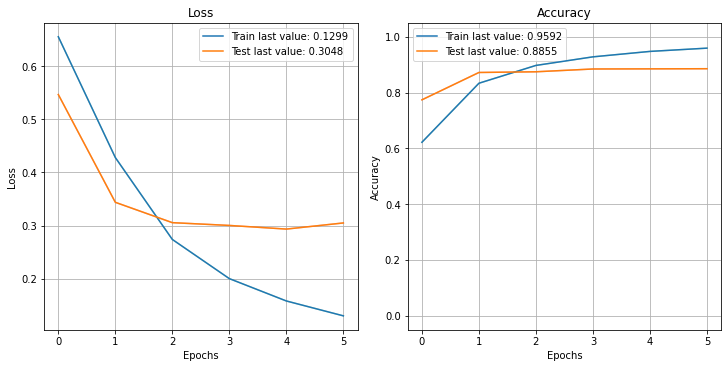

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results = model_2.evaluate(padded_test_data, test_labels, batch_size=1000)

print('test_loss:', results[0], 'test_accuracy:', results[1])

25/25 [==============================] - 3s 98ms/step - loss: 0.3411 - accuracy: 0.8708
test_loss: 0.3411269783973694 test_accuracy: 0.8708000183105469


#### Adding early stopping

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=1, mode='min', verbose=1, min_delta=0.01)

In [ ]:
history = model_2.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y), callbacks = [callback])

Epoch 1/6
23/23 [==============================] - 17s 585ms/step - loss: 0.6271 - accuracy: 0.6621 - val_loss: 0.4690 - val_accuracy: 0.8210
Epoch 2/6
23/23 [==============================] - 13s 548ms/step - loss: 0.3601 - accuracy: 0.8608 - val_loss: 0.3034 - val_accuracy: 0.8735
Epoch 3/6
23/23 [==============================] - 13s 548ms/step - loss: 0.2411 - accuracy: 0.9110 - val_loss: 0.3056 - val_accuracy: 0.8860
Epoch 3: early stopping


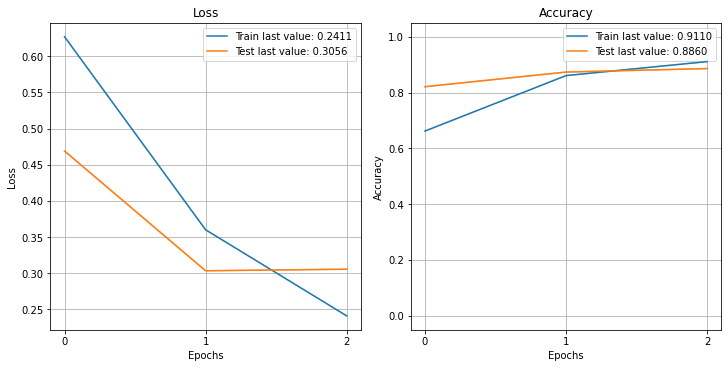

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results = model_2.evaluate(padded_test_data, test_labels, batch_size=1000)

print('test_loss:', results[0], 'test_accuracy:', results[1])

25/25 [==============================] - 2s 96ms/step - loss: 0.3338 - accuracy: 0.8697
test_loss: 0.3338252007961273 test_accuracy: 0.8697199821472168


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


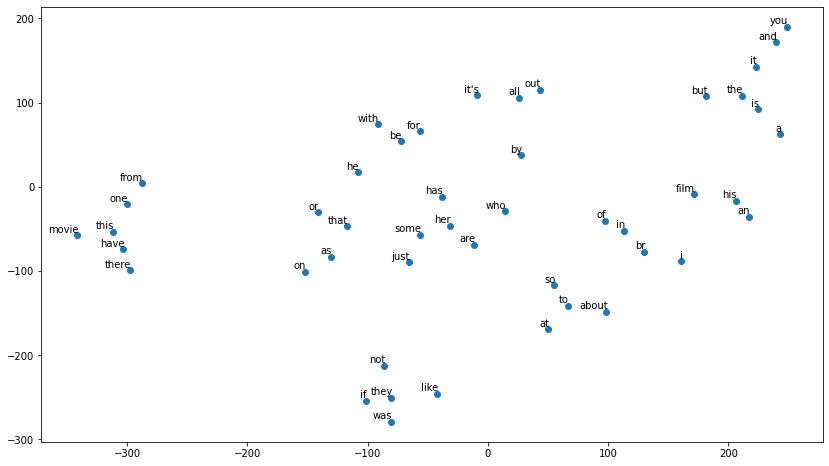

In [ ]:
word_embeddings = model_2.get_layer('embed_layer').get_weights()[0]

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        


## Question 2 - Model with different batch sizes

Model fit to batch size = 1

In [ ]:
model = Model(inputs=[input_1], outputs=[dense_1])
model.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics=['accuracy'])

history1 = model.fit(train_x, train_y, epochs=6, batch_size=1, validation_data=(validation_x, validation_y),  callbacks = [callback])

Epoch 1/6
11522/23000 [==============>...............] - ETA: 2:21:03 - loss: 0.4656 - accuracy: 0.7842

KeyboardInterrupt: ignored

Model fit to batch size = 32

In [ ]:
model = Model(inputs=[input_1], outputs=[dense_1])
model.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics=['accuracy'])

history1 = model.fit(train_x, train_y, epochs=6, batch_size=32, validation_data=(validation_x, validation_y),  callbacks = [callback])

Epoch 1/6
719/719 [==============================] - 638s 881ms/step - loss: 0.4876 - accuracy: 0.7603 - val_loss: 0.3436 - val_accuracy: 0.8620
Epoch 2/6
719/719 [==============================] - 643s 894ms/step - loss: 0.3318 - accuracy: 0.8629 - val_loss: 0.3762 - val_accuracy: 0.8610
Epoch 2: early stopping


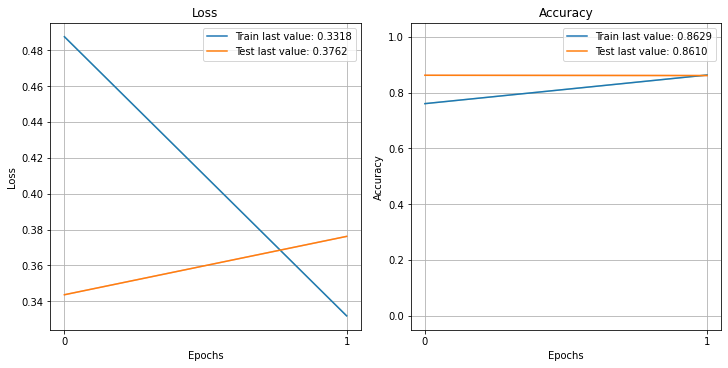

In [ ]:
plot_history(history1.history, path="standard.png")
plt.show()

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results = model.evaluate(padded_test_data, test_labels, batch_size=32)

print('test_loss:', results[0], 'test_accuracy:', results[1])

782/782 [==============================] - 62s 79ms/step - loss: 0.3884 - accuracy: 0.8571
test_loss: 0.3883788585662842 test_accuracy: 0.8570799827575684


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


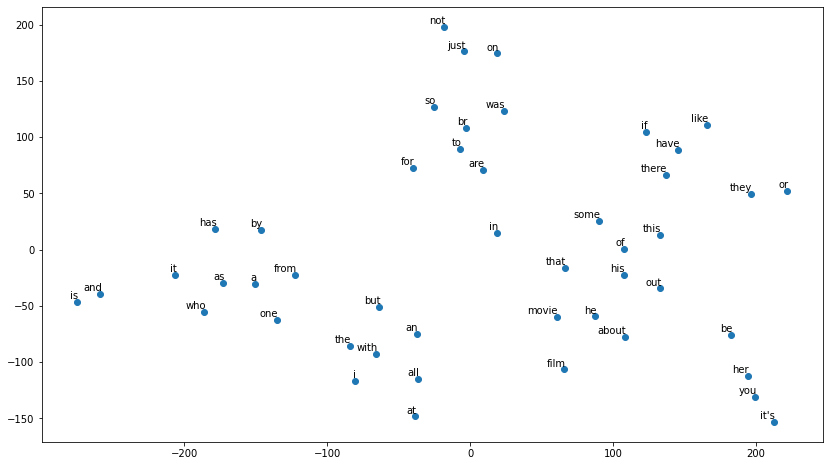

In [ ]:
word_embeddings = model.get_layer('embed_layer').get_weights()[0]

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        


Model fit to batch size = length of data

In [ ]:
model = Model(inputs=[input_1], outputs=[dense_1])
model.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics=['accuracy'])

history1 = model.fit(train_x, train_y, epochs=6, batch_size=len(train_x), validation_data=(validation_x, validation_y),  callbacks = [callback])

Epoch 1/6


ResourceExhaustedError: ignored

BiDirectional LSTM

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Dropout, Bidirectional
from keras.models import Model

EMBED_SIZE = 100
# YOUR CODE GOES HERE

input_1 = Input(shape=(500,), dtype='int32')
embedding_1 = Embedding( input_length=500, input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, name='embed_layer',
                        embeddings_initializer='glorot_uniform', mask_zero=True)(input_1)
lstm_1 = Bidirectional(LSTM(100))(embedding_1)
dropout_2 = Dropout(rate=0.2)(lstm_1)
dense_1 = Dense(1, activation='sigmoid')(dropout_2)

model = Model(inputs=[input_1], outputs=[dense_1])

model.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 500)]             0         
                                                                 
 embed_layer (Embedding)     (None, 500, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout_11 (Dropout)        (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,161,001
Trainable params: 1,161,001
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y),  callbacks = [callback])

Epoch 1/6
23/23 [==============================] - 29s 1s/step - loss: 0.6377 - accuracy: 0.6559 - val_loss: 0.4776 - val_accuracy: 0.7940
Epoch 2/6
23/23 [==============================] - 21s 909ms/step - loss: 0.4127 - accuracy: 0.8193 - val_loss: 0.3620 - val_accuracy: 0.8570
Epoch 3/6
23/23 [==============================] - 21s 916ms/step - loss: 0.3262 - accuracy: 0.8723 - val_loss: 0.3225 - val_accuracy: 0.8635
Epoch 4/6
23/23 [==============================] - 21s 909ms/step - loss: 0.2746 - accuracy: 0.8980 - val_loss: 0.2998 - val_accuracy: 0.8840
Epoch 5/6
23/23 [==============================] - 21s 908ms/step - loss: 0.2196 - accuracy: 0.9237 - val_loss: 0.3021 - val_accuracy: 0.8835
Epoch 5: early stopping


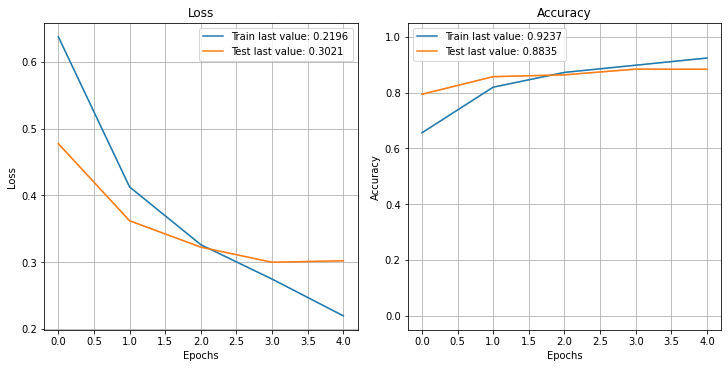

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

In [ ]:
results = model.evaluate(padded_test_data, test_labels, batch_size=1000)
print('test_loss:', results[0], 'test_accuracy:', results[1])

25/25 [==============================] - 5s 219ms/step - loss: 0.3279 - accuracy: 0.8676
test_loss: 0.3279435932636261 test_accuracy: 0.8676000237464905


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


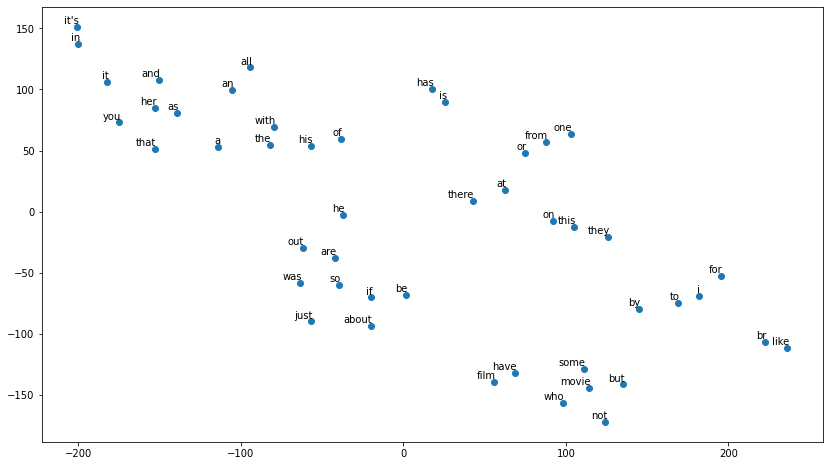

In [ ]:
word_embeddings = model.get_layer('embed_layer').get_weights()[0]

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        
